### <center> Examples of Image Decoding and Recovery using Shearlet transform </center>

We will compute the Digital Shearlet Transform of a signal $f$ by the equation
$$\text{DST}_{j,k,m}^{2D}(f) = \left(\overline{\psi^d_{j,k}}*f_J\right)\left(2^J A_{2^j}^{-1}M_{c_j}m\right) \text{ for } j=0,1,...,J-1 $$

where $\psi^d_{j,k} = S^d_{k/2^{j/2}}(p_j*W_j)$ ( with $S^d_{k/2^{j/2}}$ the digital shearing operator already implemented, $p_j(n)$ are the Fourier coefficients of the fan filter P (associated to the shearlet generator function) and $W_j=g_{J-j}\otimes h_{J-j}$ ($h_j$ low-pass filter associated to the scaling function and $g_j$ high pass filter, mirror filter of h, associated to the wavelet function), and $A_{2^j}$ is the parabolic scaling matrix given by
$$ A_{2^j} = \left( \begin{matrix} 2^j & 0 \\ 0 & 2^{j/2} \end{matrix}\right) $$
and the Shearing transform is given by
$$ S_k = \left( \begin{matrix} 1 & k \\ 0 & 1 \end{matrix}\right)$$

Lets define the scaling and wavelet filters now in each scale by:
$$ 
\hat{h}_j(\xi_1)=\prod_{k=0}^{j-1}\hat{h}(2^k\xi_1) 
\text{    ,    }  
\hat{g}_j(\xi_1)=\hat{g}\left(\frac{2^j\xi_1}{2}\right) \hat{h}_{j-1}(\xi_1)
$$
and the directional filter transform 
$p_j(\xi_1,\xi_2)=\widehat{P(2^{J-j-1}\xi_1,2^{J-j/2}\xi_2)}$
for that one need to apply padding to the directional filter, looking carefully to $p_j*W_j=p_j*g_{J-j}\otimes h_{J-j}$ that is the vertical wavelet transform of the filter $p_j$.

#### Non separable transform and Digital Shearing.

In this case it was used a nonseparable shearlet generator
$$
\hat{\psi}(\xi)=P(\xi_1/2,\xi_2/2)\widehat{\psi_1\otimes \phi_1}(\xi)
$$
Because of $\psi_{j,k,m}(\cdot) = \psi_{j,0,m}(S_{k/2^{j/2}\cdot}$ and $\psi_{j,0}^{2D}=p_j*(g_{J-j}\otimes h_{J-j/2})$,the digital shearing to mantain the domain grid will be
$$
S_{k/2^{j/2}}(x)=\left(\left( x_{\uparrow 2^{j/2}}*_1h_{j/2}\right)(S_k\cdot)*_1\overline{h_{j/2}}\right)_{\downarrow 2^{j/2}}
$$
therefore 
$$
\psi_{j,k}^{2D} = S^d_{k/2^{j/2}}\psi_{j,0}^{2D}
$$
for $j\in\{0,J-1\}$ and $|k|\leq \lceil 2^{j/2}\rceil$.

In [1]:
# Clone the libraris
#Pkg.clone("https://github.com/arsenal9971/Shearlab.jl.git")

In [1]:
# Loard the Pkg
push!(LOAD_PATH,pwd()*"/../../src") 
import Shearlab
using PyPlot
reload("Shearlab")

In [9]:
# Read Data
n = 512;
# The path of the image
name = "../../data_samples/flowers.png";
data = Shearlab.load_image(name, n);
#Rescale image in [0,1] summing the 3 arrays in the RGB format
data = Shearlab.rescale(sum(data,3));

libpng warning: iCCP: known incorrect sRGB profile


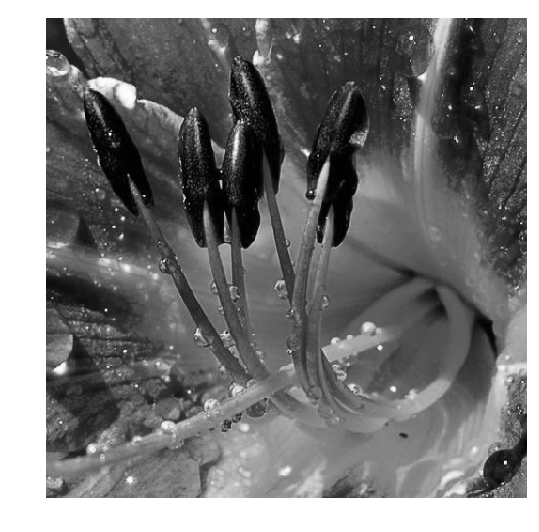

In [10]:
# Reduce one dimension 
data = data[:,:,1];
Shearlab.imageplot(data);

In [11]:
sizeX = size(data,1);
sizeY = size(data,2);

In [12]:
# Set the variables for the Shearlet trasform
rows = sizeX;
cols = sizeY;
X = data; 
nScales = 2;

In [13]:
# Compute the corresponding shearlet system
tic()
shearletSystem = Shearlab.SLgetShearletSystem2D(rows,cols,nScales);
toc()

elapsed time: 14.157844132 seconds


14.157844132

**Lets look at the shearlets at different scales.**

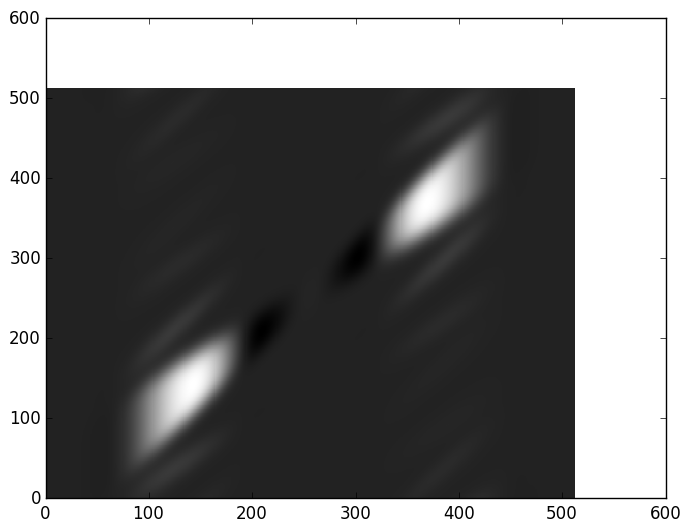

PyObject <matplotlib.collections.QuadMesh object at 0x326b811d0>

In [16]:
shearlet1 = shearletSystem.shearlets[:,:,1];
pcolormesh(real(shearlet1))

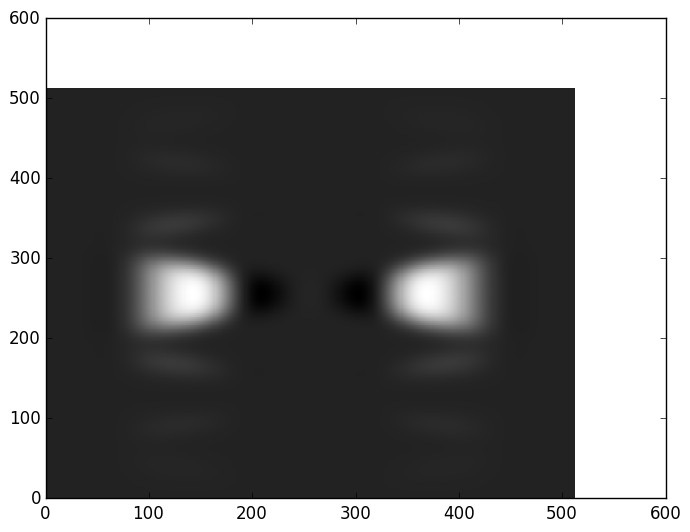

PyObject <matplotlib.collections.QuadMesh object at 0x324cad990>

In [19]:
shearlet3 = shearletSystem.shearlets[:,:,3];
pcolormesh(real(shearlet3))

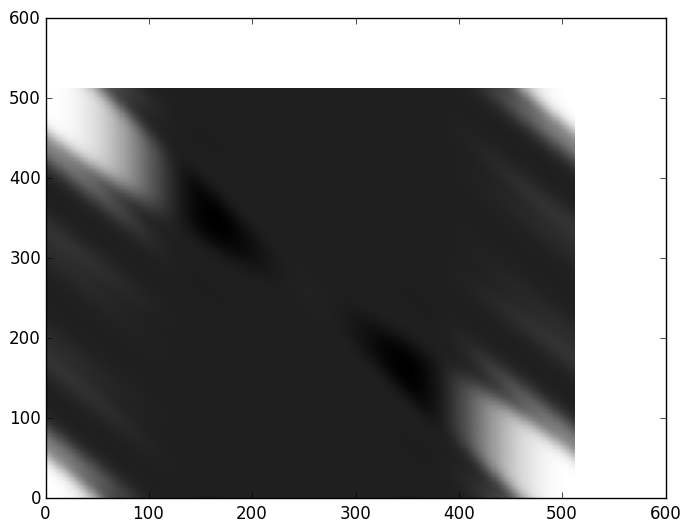

PyObject <matplotlib.collections.QuadMesh object at 0x3210aed10>

In [18]:
shearlet10 = shearletSystem.shearlets[:,:,10];
pcolormesh(real(shearlet10))

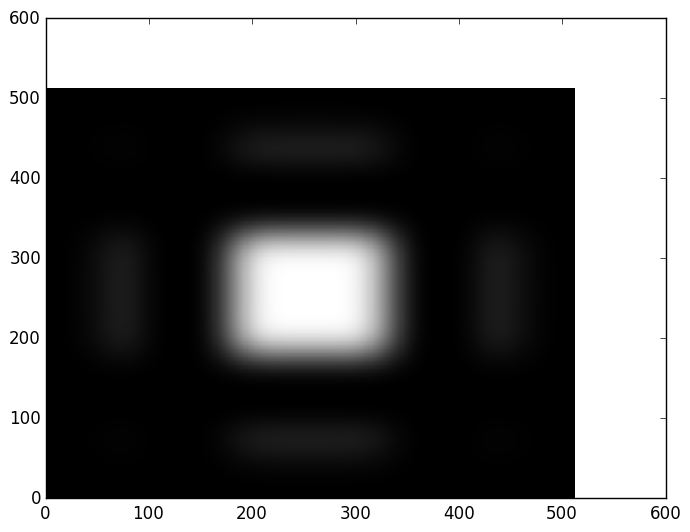

PyObject <matplotlib.collections.QuadMesh object at 0x327412510>

In [20]:
shearlet17 = shearletSystem.shearlets[:,:,17];
pcolormesh(real(shearlet17))

**Lets compute the shearlet coefficients for the data**

In [21]:
# Compute the coefficients
tic()
coeffs = Shearlab.SLsheardec2D(X,shearletSystem);
toc()

elapsed time: 1.130993632 seconds


1.130993632

**Lets look at the shearlets coefficients at different scales.**

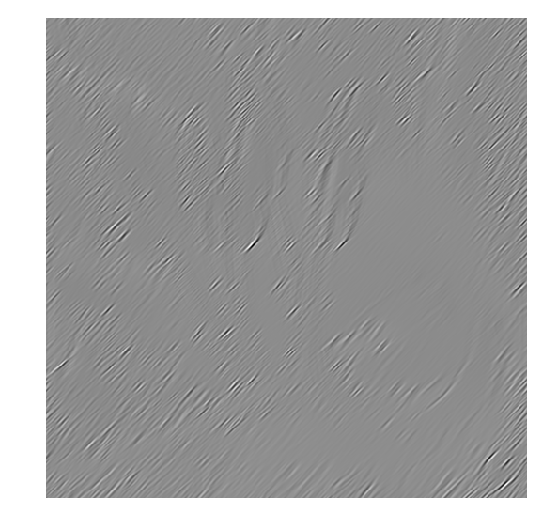

In [24]:
Shearlab.imageplot(real(coeffs[:,:,1]))

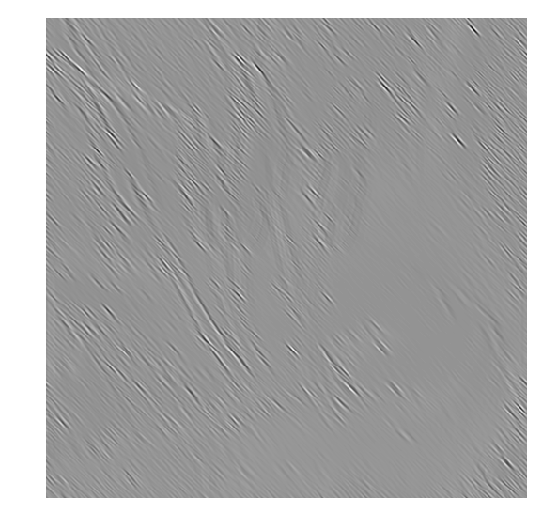

In [26]:
Shearlab.imageplot(real(coeffs[:,:,5]))

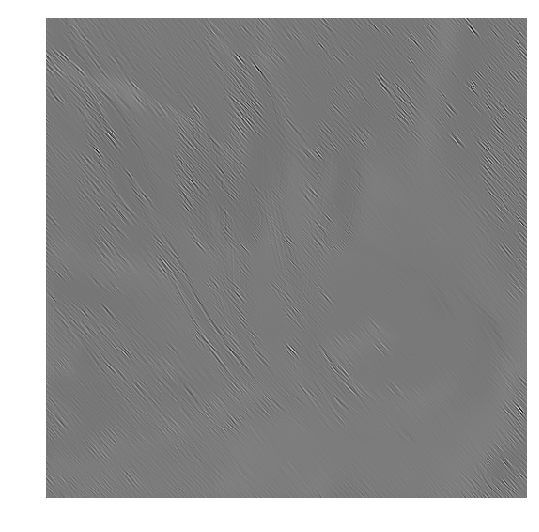

In [27]:
Shearlab.imageplot(real(coeffs[:,:,10]))

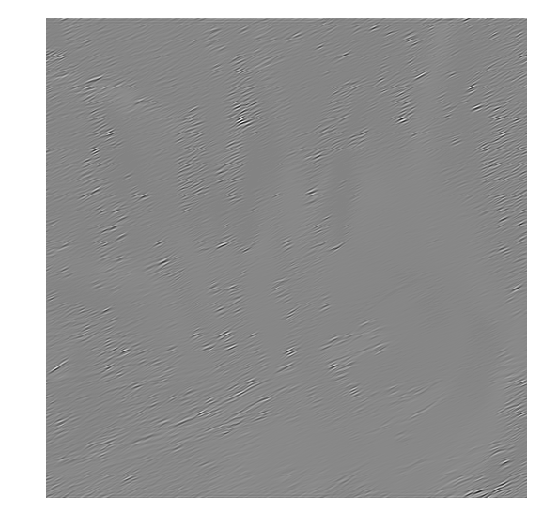

In [29]:
Shearlab.imageplot(real(coeffs[:,:,16]))

**Lets compute the shearlet reconstruction of the data**

In [30]:
# Make the recovery
tic()
Xrec=Shearlab.SLshearrec2D(coeffs,shearletSystem);
toc()

elapsed time: 0.775245581 seconds


0.775245581

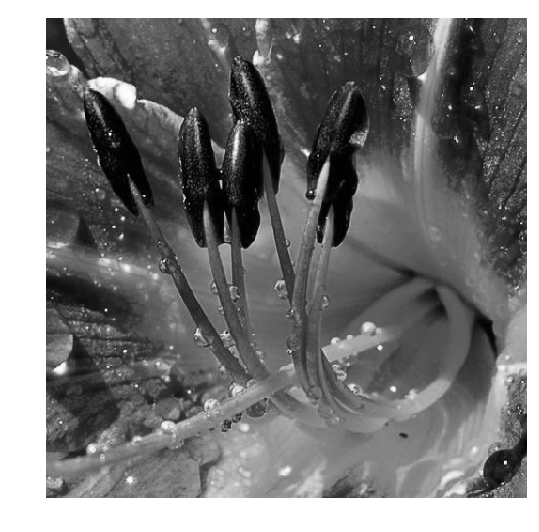

In [31]:
# The recovery is very good
Shearlab.imageplot(Xrec);